In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from segmentation_models import Linknet
from segmentation_models.utils import set_trainable

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.applications.resnet50 import ResNet50
from keras.models import Model, load_model
from keras.layers import Input , Concatenate
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.initializers import he_normal
from keras.regularizers import l2
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *
from keras.utils import to_categorical
from keras.losses import binary_crossentropy
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
im_width = 256
im_height = 256
border = 5
im_chan = 3
n_features = 1 
path_train = 'data/train/'
path_test = 'data/test/'

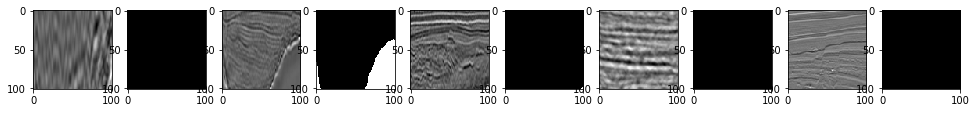

In [3]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('data/train/images/' + img_name + '.png')
    img_mask = load_img('data/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [4]:
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), 256, 256 , 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
sum_whites = 0
for n, id_ in enumerate(train_ids):
    path = path_train
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (256, 256 , 3), preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (256, 256, 1), preserve_range=True)
    sum_whites += np.sum(Y_train[n])

print('Done!')

print("Salt in the dataset is {}".format(sum_whites*1.0 / (X_train.shape[0] * 256*256)))

Getting and resizing train images and masks ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Done!
Salt in the dataset is 0.24794946670532225


In [6]:
Y_train[0].shape

(256, 256, 1)

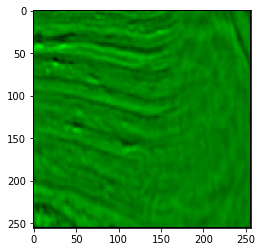

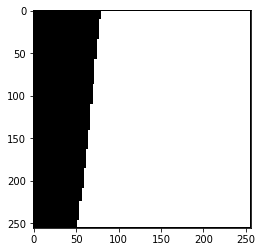

In [7]:
ix = random.randint(0, len(train_ids))
plt.imshow(X_train[ix])
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [8]:
X_train , X_val , Y_train , Y_val = train_test_split(X_train , Y_train , train_size = 0.9 , random_state = 181)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
image_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

mask_generator = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip = True,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2
)

val_image_generator = ImageDataGenerator(
)
val_mask_generator = ImageDataGenerator(
)

train_img_gen = image_generator.flow(X_train , seed = 181 , batch_size = 16)
train_mask_gen = mask_generator.flow(Y_train , seed = 181 , batch_size = 16)

val_img_gen = val_image_generator.flow(X_val , seed = 181 , batch_size = 16)
val_mask_gen = val_mask_generator.flow(Y_val , seed = 181 , batch_size = 16)

In [10]:
train_gen = zip(train_img_gen , train_mask_gen)
val_gen = zip(val_img_gen , val_mask_gen)

In [11]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [12]:
model = Linknet(backbone_name='resnet34', input_shape = (256,256,3))

In [13]:
# def dice_coef(y_true, y_pred):
#     y_true_f = K.flatten(y_true)
#     y_pred = K.cast(y_pred, 'float32')
#     y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
#     intersection = y_true_f * y_pred_f
#     score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
#     return score

# def dice_loss(y_true, y_pred):
#     smooth = 1.
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     intersection = y_true_f * y_pred_f
#     score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
#     return 1. - score

# def bce_dice_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# def bce_logdice_loss(y_true, y_pred):
#     return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

# def weighted_bce_loss(y_true, y_pred, weight):
#     epsilon = 1e-7
#     y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
#     logit_y_pred = K.log(y_pred / (1. - y_pred))
#     loss = weight * (logit_y_pred * (1. - y_true) + 
#                      K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
#     return K.sum(loss) / K.sum(weight)

# def weighted_dice_loss(y_true, y_pred, weight):
#     smooth = 1.
#     w, m1, m2 = weight, y_true, y_pred
#     intersection = (m1 * m2)
#     score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
#     loss = 1. - K.sum(score)
#     return loss

# def weighted_bce_dice_loss(y_true, y_pred):
#     y_true = K.cast(y_true, 'float32')
#     y_pred = K.cast(y_pred, 'float32')
#     # if we want to get same size of output, kernel size must be odd
#     averaged_mask = K.pool2d(
#             y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
#     weight = K.ones_like(averaged_mask)
#     w0 = K.sum(weight)
#     weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
#     w1 = K.sum(weight)
#     weight *= (w0 / w1)
#     loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
#     return loss
  
# def focal_loss(gamma=2., alpha=.25):
#     def focal_loss_fixed(y_true, y_pred):
#         pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
#         pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
#         return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
#     return focal_loss_fixed

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [15]:
model.compile(optimizer = Adam(lr=1e-4) , loss = 'binary_crossentropy' , metrics = [mean_iou , 'acc'])

In [16]:
lr_reducer = ReduceLROnPlateau(monitor = 'val_mean_iou' , factor = 0.5 , 
                               mode = 'max' , patience = 5 , verbose = 2 , min_delta = 0.01)
checkpointer = ModelCheckpoint('resnet34_linknet_181.h5', monitor='val_mean_iou', 
                               verbose=2, save_best_only=True , save_weights_only = False , mode = 'max')
early_stopper = EarlyStopping(monitor = 'val_mean_iou' , mode = 'max' , patience = 10)

In [17]:
results = model.fit_generator(train_gen , steps_per_epoch = 1125 , epochs = 100 ,
                              validation_data = val_gen , validation_steps = 25 ,
                              callbacks=[checkpointer , lr_reducer, early_stopper] , verbose = 1)

Epoch 1/100
1125/1125 [==============================] - 339s 302ms/step - loss: 0.2181 - mean_iou: 0.5768 - acc: 0.9012 - val_loss: 0.1834 - val_mean_iou: 0.6975 - val_acc: 0.9358

Epoch 00001: val_mean_iou improved from -inf to 0.69747, saving model to resnet34_linknet_181.h5
Epoch 2/100
1125/1125 [==============================] - 327s 290ms/step - loss: 0.1417 - mean_iou: 0.7262 - acc: 0.9448 - val_loss: 0.1458 - val_mean_iou: 0.7512 - val_acc: 0.9487

Epoch 00002: val_mean_iou improved from 0.69747 to 0.75120, saving model to resnet34_linknet_181.h5
Epoch 3/100
1125/1125 [==============================] - 319s 283ms/step - loss: 0.1311 - mean_iou: 0.7602 - acc: 0.9500 - val_loss: 0.1329 - val_mean_iou: 0.7739 - val_acc: 0.9491

Epoch 00003: val_mean_iou improved from 0.75120 to 0.77394, saving model to resnet34_linknet_181.h5
Epoch 4/100
1125/1125 [==============================] - 321s 286ms/step - loss: 0.1166 - mean_iou: 0.7817 - acc: 0.9545 - val_loss: 0.1235 - val_mean_iou: 0

1125/1125 [==============================] - 323s 287ms/step - loss: 0.0420 - mean_iou: 0.8906 - acc: 0.9826 - val_loss: 0.1903 - val_mean_iou: 0.8914 - val_acc: 0.9503

Epoch 00030: val_mean_iou improved from 0.88973 to 0.89145, saving model to resnet34_linknet_181.h5
Epoch 31/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0419 - mean_iou: 0.8922 - acc: 0.9828 - val_loss: 0.1589 - val_mean_iou: 0.8930 - val_acc: 0.9586

Epoch 00031: val_mean_iou improved from 0.89145 to 0.89304, saving model to resnet34_linknet_181.h5
Epoch 32/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0391 - mean_iou: 0.8938 - acc: 0.9837 - val_loss: 0.1649 - val_mean_iou: 0.8947 - val_acc: 0.9600

Epoch 00032: val_mean_iou improved from 0.89304 to 0.89469, saving model to resnet34_linknet_181.h5

Epoch 00032: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 33/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0

Epoch 58/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0232 - mean_iou: 0.9255 - acc: 0.9899 - val_loss: 0.1457 - val_mean_iou: 0.9259 - val_acc: 0.9696

Epoch 00058: val_mean_iou improved from 0.92517 to 0.92594, saving model to resnet34_linknet_181.h5
Epoch 59/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0217 - mean_iou: 0.9263 - acc: 0.9901 - val_loss: 0.1333 - val_mean_iou: 0.9267 - val_acc: 0.9695

Epoch 00059: val_mean_iou improved from 0.92594 to 0.92670, saving model to resnet34_linknet_181.h5

Epoch 00059: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
Epoch 60/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0224 - mean_iou: 0.9270 - acc: 0.9900 - val_loss: 0.1232 - val_mean_iou: 0.9274 - val_acc: 0.9674

Epoch 00060: val_mean_iou improved from 0.92670 to 0.92743, saving model to resnet34_linknet_181.h5
Epoch 61/100
1125/1125 [==============================] - 323s 287ms/st


Epoch 00085: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
Epoch 86/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0221 - mean_iou: 0.9404 - acc: 0.9901 - val_loss: 0.1707 - val_mean_iou: 0.9406 - val_acc: 0.9662

Epoch 00086: val_mean_iou improved from 0.94027 to 0.94063, saving model to resnet34_linknet_181.h5
Epoch 87/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0199 - mean_iou: 0.9408 - acc: 0.9906 - val_loss: 0.1432 - val_mean_iou: 0.9410 - val_acc: 0.9737

Epoch 00087: val_mean_iou improved from 0.94063 to 0.94100, saving model to resnet34_linknet_181.h5
Epoch 88/100
1125/1125 [==============================] - 323s 287ms/step - loss: 0.0215 - mean_iou: 0.9412 - acc: 0.9903 - val_loss: 0.1982 - val_mean_iou: 0.9413 - val_acc: 0.9617

Epoch 00088: val_mean_iou improved from 0.94100 to 0.94135, saving model to resnet34_linknet_181.h5
Epoch 89/100
1125/1125 [==============================] - 323s 287ms/

In [18]:
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in enumerate(test_ids):
    path = path_test
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (256, 256, 3) , preserve_range=True)
    X_test[n] = x

print('Done!')

Getting and resizing test images ... 


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Done!


In [19]:
model = load_model("resnet34_linknet_181.h5" , custom_objects = {'mean_iou' : mean_iou})

In [20]:
preds_val = model.predict(X_val, verbose=1 , batch_size = 2)
preds_test = model.predict(X_test , verbose = 1 , batch_size = 2)

preds_val_t = (preds_val > 0.5).astype(np.uint8)

18000/18000 [==============================] - 156s 9ms/step


In [21]:
model.evaluate(X_val , Y_val , verbose = 1)

400/400 [==============================] - 11s 26ms/step


[0.1701519101858139, 0.8377501392364501, 0.9663067626953125]

In [22]:
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (101, 101), 
                                       mode='constant', preserve_range=True))

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    
    union = area_true + area_pred - intersection

    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union

    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thres = np.linspace(0.25, 0.75, 20)
thres_ioc = [iou_metric_batch(Y_val, np.int32(preds_val > t)) for t in thres]

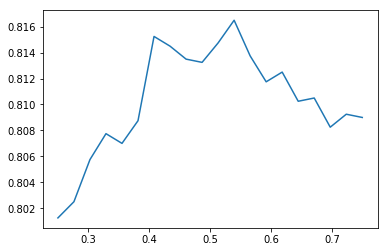

In [25]:
plt.plot(thres, thres_ioc)

In [26]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(0.5394736842105263, 0.8165)

In [27]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i] > best_thres)) for i,fn in enumerate(test_ids)}

In [28]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')